For the paper:
- Use https://arxiv.org/abs/1706.06103 for scattering
- Use term "optical depth" instead of lensing fraction, check that out
- Update parameters with https://arxiv.org/pdf/2208.00819.pdf
- Scattering in lens: 
    - https://arxiv.org/pdf/1706.06103.pdf
    - https://iopscience.iop.org/article/10.1088/0004-637X/776/2/125/pdf
- Compare rates to https://arxiv.org/pdf/2206.14310.pdf


TODO
- Update parameters with Clancy model
- Use "rate interpretation" of alpha (https://arxiv.org/pdf/2101.08005.pdfhttps://arxiv.org/pdf/2101.08005.pdf)
- Add other telescopes
- Add uncertainties
- Add magnification factor
- Add scattering horizon
- Same number of FRBs for lensed simulations
- Revise total rate for multi-band searches
- Try FoV at middle of the band

In [1]:
import warnings
warnings.filterwarnings("error")

In [2]:
import sys
sys.path.append("/arc/home/michilli/.local/lib/python3.8/site-packages/")

In [3]:
# Python 3.8.16
import os
import pickle
import datetime
import itertools

# Numpy 1.24.2
import numpy as np
from numpy.random import default_rng
# matplotlib 3.7.1
import matplotlib.pyplot as plt
# astropy 5.2.1
from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo
# scipy 1.9.3
from scipy.special import j1
from scipy import optimize
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import CubicSpline as spline
from scipy import integrate
# mpmath 1.3.0
from mpmath import gammainc



# Classes and functions

class Telescope:
    """
    Telescope parameters
    """
    parameters = {
        'dummy': {  # test parameters
            'Srec': 15 * u.Jy,
            'v0': 800 * u.MHz,
            'v1': 1600 * u.MHz,
            'D': 50 * u.m,
            'bands': [
                [800 * u.MHz, 1200 * u.MHz],
                [1200 * u.MHz, 1600 * u.MHz],
            ]
        },
        'chime': {  # from https://ui.adsabs.harvard.edu/abs/2022ApJS..261...29C/abstract
            # from https://ui.adsabs.harvard.edu/abs/2017ApJ...844..140C/abstract
            'Srec': 50 / 1.38 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,            
            'Dx': 20 * u.m,
            'Dy': 0.87 * u.m,  # Emprirical value to have a beam of ~100 deg
        },
        'utmost': {  # from https://arxiv.org/pdf/1708.09619.pdf
            'Srec': 115 * np.sqrt(2) * u.Jy,  # The sqrt(2) correction is for the single polarization
            'gain': 0.5 * u.K / u.Jy,
            'v0': 836 * u.MHz,
            'v1': 850 * u.MHz,            
            'Dx': 11.6 * u.m,
            'Dy': 0.88 * (835 * u.MHz).to(u.m, equivalencies=u.spectral()) / (4.25 * u.deg).to(u.rad).value,  # Value to have a FWHP=4.25deg
        },
        'chord': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 * u.K / 9 / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 6 * u.m,
            'bands': [
                [300 * u.MHz, 700 * u.MHz],
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
            ]
        },
        'dsa2000': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,
            'gain': 25 * u.K / 2.5 / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 2000 * u.MHz,
            'D': 5 * u.m,
            'bands': [
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
                [1500 * u.MHz, 2000 * u.MHz],
            ]
        },
        'aperitif': {  # from https://www.aanda.org/articles/aa/full_html/2022/02/aa41739-21/aa41739-21.html
            'Srec': 560 * u.Jy,
            'gain': 70 / 560 * u.K / u.Jy,
            'v0': (1370 - 300/2) * u.MHz,
            'v1': (1370 + 300/2) * u.MHz,            
            'D': 25 * u.m,
        },
        'fast': {  # from https://ui.adsabs.harvard.edu/abs/2016RaSc...51.1060L/abstract
            'Srec': 20 * u.K / (18 * u.K / u.Jy),
            'gain': 18 * u.K / u.Jy,
            'v0': 1220 * u.MHz,
            'v1': 1520 * u.MHz,            
            'D': 300 * u.m,
        },
        'askap': {  # from https://ui.adsabs.harvard.edu/abs/2016PASA...33...42M/abstract
            'Srec': 2000 * u.Jy,
            'gain': 115 * u.K / 4000 / u.Jy,
            'v0': (1320 - 336/2) * u.MHz,
            'v1': (1320 + 336/2) * u.MHz,            
            'D': 12 * u.m,
        },
        'parkes': {  # from https://arxiv.org/pdf/astro-ph/0106522.pdf
            'Srec': 21 / 0.7 * u.Jy,
            'gain': 0.7 * u.K / u.Jy,
            'v0': (1374 - 288/2) * u.MHz,
            'v1': (1374 + 288/2) * u.MHz,            
            'D': 64 * u.m,
        },
    }
    
    def __init__(self, name='chord'):
        self.name = name
        self.parameters = Telescope.parameters
        try:
            _ = self.parameters[name]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]
    
    def bandwidth(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1'] - self.parameters[name]['v0']
    
    def sefd(self, name = None, freq = None, uncertain = False):
        if name is None: name = self.name
        if freq is None:
            freq = (
                self.parameters[name]['v0'] + 
                self.parameters[name]['v1']
            ) / 2
        sefd = (
            self.parameters[name]['Srec'] + 
            34 * u.K * (freq / 408 / u.MHz)**-2.6 / 
            self.parameters[name]['gain']
        )
        if uncertain:
            # Add an error of 20%
            sefd = rng.normal(
                loc=sefd.to(u.Jy).value,
                scale=sefd.to(u.Jy).value * 0.2
            ) * u.Jy
        return sefd
    
    def v0(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v0']
    
    def v1(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1']
    
    def frequency_bands(self, name = None):
        if name is None: name = self.name
        try:
            return self.parameters[name]['bands']
        except KeyError:
            return [[
                self.parameters[name]['v0'],
                self.parameters[name]['v1']
            ]]
    
    def get_parameter(self, parameter, name = None):
        if name is None: name = self.name
        return self.parameters[name][parameter]

    
class FRB_Population:
    """
    Parameters of the FRB population.
    """
    parameters = {
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': [2.38e41, +5.35e41, -1.64e41] * u.erg,  # Characteristic energy cut-of
            'alpha_spect': [-1.39, +0.86, -1.19],  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': [-1.3, +0.7, -0.4],  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [7.3e4, +8.8e4, -3.8e4] / u.Gpc**3/u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': [0.96, +0.81, -0.67],  # Index of star-formation rate
        },
        'shin_rate_interpretation': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': [1.95e41, +3.75e41, -1.28e41] * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': [-1.10, +0.67, -0.99],  # Spectral index
            'gamma': [-1.3, +0.8, -0.5],  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [6.8e4, +8.3e4, -3.6e4] / u.Gpc**3/u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': [1.72, +1.48, -1.10],  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': [1.82e41, +1.57e41, -7.23e40]  * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': [-0.99, +0.99, -1.01],  # Spectral index
            'gamma': [-0.95-1, +0.18, -0.15],  # Differential power-law index
            'n_sfr': [1.13, +0.49, -0.41],  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': (10**1.96 / u.Mpc**3/u.day).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        self.parameters = FRB_Population.parameters
        try:
            _ = self.parameters[self.model]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
            
    def get_uncert_params(self, model = None):
        if model is None: model = self.model
        parameters = dict(self.parameters[model])
        ii = 0
        for key,value in parameters.items():
            try:
                size = len(value)
                ii += 1
            except TypeError:
                # No uncertianty for single values
                continue
        return ii
                


    
def get_lensed_fraction(
    zmin,
    zmax,
    frbs_evolve_with_luminosity = True,
):
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Ensures that there are ~1000 galaxies per step on average
    z = np.linspace(zmin, zmax, lensed_galaxies_z.size//1000+1)
    z_mean = (z[1:] + z[:-1]) / 2
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
    
    # Lensed and total galaxies per redshift bin
    Pz_sim, _ = np.histogram(lensed_galaxies_z, bins=z)
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = (Pz_sim > 10) & (Pz_org > 10)
    Pz_sim = Pz_sim[idx]
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
        
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_bol) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        L_sim = lensed_galaxies_Mv.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            lensed_galaxies_z, 
            bins=z, 
            weights=L_sim
        )
        PL_sim = PL_sim[idx]
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim / PL_org

    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = Pz_sim / Pz_org
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    cs = spline(z_mean, lensed_fraction, extrapolate=False)
    
    return cs, z_mean.min(), z_mean.max()


def get_distribution_redshift(
    number_of_simulated_frbs,
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
):
    """Redshift distribution for a population of FRBs not evolving with redshift.
    """
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        cosmo.differential_comoving_volume(z)*u.sr / 
        (1 + z)**(1-alpha_rate) * (sfr(z) / sfr(0))**n_sfr
    ).to(1/u.yr).value
    frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max

    # Rejection sampling the distribution
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x
    return z_dist, z_min, z_max, frb_emission_rate / u.yr


def get_distribution_dist(
    number_of_simulated_frbs,
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = True,
):
    """Distribution of the distance factor.
    """
    if z_max is None:
        z_max = lensed_galaxies_z.max()
    if z_min is None:
        z_min = lensed_galaxies_z.min()
        
    # Fraction of lensed galaxies cataloged by Euclid vs redshift
    if simulate_lensed_frbs:
        lensed_fraction_interp, z_min, z_max = get_lensed_fraction(
            z_min,
            z_max,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        )
    
    # Redshift distribution of FRBs in the Universe
    z_dist, z_min, z_max, frb_emission_rate = get_distribution_redshift(
        number_of_simulated_frbs,
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )
    
    # Only simulate lensed FRBs
    if simulate_lensed_frbs:
        P_z = lensed_fraction_interp(z_dist)
        P_random = rng.uniform(size=P_z.size)
        z_dist = z_dist[P_random <= P_z]
    
    # Distance factor
    Dl = cosmo.luminosity_distance(z_dist)
    dist_factor = (4 * np.pi * Dl**2) / (1 + z_dist)**(2+alpha_spect)
    
    return dist_factor, z_min, z_max, frb_emission_rate, z_dist


def get_bandwidth(
    number_of_simulated_frbs,
    bw_telescope,
    bw_min = 50 * u.MHz,
    loc = 400 * u.MHz,  # MHz
    scale = 400 / 2 * u.MHz,  # MHz
):
    """Assume that the bandwidth of FRBs is a normal distribution based on CHIME detections."""
    # Bandwidth distribution from a truncated normal distribution
    bw_clip = (bw_min - loc) / scale
    bw = truncnorm.rvs(
        bw_clip, 
        np.inf, 
        loc=loc, 
        scale=scale,
        size=number_of_simulated_frbs,
        random_state=rng
    ) * u.MHz
    return bw

def get_energy_minimum(
    bw,
    sefd,
    frb_bw,
    w,
    tau,
    dist_factor,
    frb_w_correction,
    frb_bw_correction,
):
    """
    Minimum FRB energy normalized to 1 GHz required to detect a burst at 
    redshift z with a signal-to-noise ratio SNr and time resolution w, 
    where rfi_band is lost due to interference.
    """
    return (
        SNr_min * np.sqrt((w + tau) / bw / 2) / frb_w_correction / frb_bw_correction * 
        sefd / np.sqrt(1 - rfi_band) * dist_factor * frb_bw
    ).min().to(u.erg)


def get_distribution_E(
    number_of_simulated_frbs,
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    # norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    norm = Emin * schechter_pdf(Emin)
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        if gamma <= -1:
            # The Pareto distribution is defined for the parameter a >= 0
            a = -gamma-1
            # Clip to avoid overflows
            x = (
                np.clip(
                    rng.pareto(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                ) + 1
            ) * Emin
        else:
            # Otherwise, use powerlaw distribution = 1 / (1 + Pareto)
            a = gamma+1
            x = (
                Emin / 
                np.clip(
                    rng.power(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                )
            )
        # PDF of proposal distribution at the random variable's values
        y_prop = (x/Emin)**gamma / Emin
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist


def get_beam_response(
    number_of_simulated_frbs,
    telescope,
    freq_min,
    min_frb_band = 50 * u.MHz,
    efficiency = 0.7
):
    # Minimum band to detect >50 MHz of a burst
    wavelength = (freq_min + min_frb_band).to(u.meter, equivalencies=u.spectral())
    # From "Tools of Radio Astronomy, by T.L. Wilson, K. Rohlfs, S. Huttemeister"
    try:
        # Circular aperture
        diameter = telescope.get_parameter('D')
        # Half beam width between the first nulls
        hwfn = (2.439 * u.rad * wavelength / diameter / 2).to(u.rad)
        # Random angles
        angle = rng.uniform(
            low=0,
            high=hwfn.to(u.rad).value**2,
            size=number_of_simulated_frbs
        )**0.5 * u.rad
        # Normalized power
        x = np.pi * np.sin(angle) * diameter / wavelength * np.sqrt(efficiency)
        power = (2 * j1(x) / x)**2
        # Simulated sky fraction
        sky_fraction = (hwfn**2 / 4 / u.steradian).value

    except KeyError:
        # Rectangular aperture
        size_x = telescope.get_parameter('Dx')
        size_y = telescope.get_parameter('Dy')
        # Half beam width between the first nulls
        hwfn_x = np.arcsin((wavelength / size_x).to(u.dimensionless_unscaled))
        hwfn_y = np.arcsin((wavelength / size_y).to(u.dimensionless_unscaled))
        # Random angles
        angle_x = rng.uniform(
            low=0, 
            high=hwfn_x.to(u.rad).value, 
            size=number_of_simulated_frbs
        ) * u.rad
        angle_y = rng.uniform(
            low=0, 
            high=hwfn_y.to(u.rad).value,
            size=number_of_simulated_frbs
        ) * u.rad
        # Normalized power
        power = (
            (
                np.sinc(np.sin(angle_x) * size_x / wavelength * u.rad) * 
                np.sinc(np.sin(angle_y) * size_y / wavelength * u.rad)
            )**2
        )
        # Simulated sky fraction
        sky_fraction = (hwfn_x * hwfn_y / 4 / np.pi / u.steradian).value

    return sky_fraction, power


def get_max_detected_redshift(
    snr,
    E_nu,
    bw,
    sefd,
    w,
    tau,
    w_correction,
    bw_correction,
    alpha_spect,
):
    """
    Maximum redshift at which an FRB of energy E would be detected
    by a telescope of sensitivity sefd
    """
    # CHECK THIS EQ
    dist_factor_Gpc2 = (
        E_nu / np.sqrt((w + tau) / bw / 2) * 
        w_correction * bw_correction / sefd * np.sqrt(1 - rfi_band)
    ).to(u.Gpc**2).max().value
    
    z_max_func = lambda z: (
        4 * np.pi * cosmo.luminosity_distance(z).to(u.Gpc).value**2 / dist_factor_Gpc2 - (1 + z)**(2+alpha_spect)
    )
    z_max = optimize.root(z_max_func, 1).x[0]
    return z_max
    

def get_snr(
    frb_E_nu,
    frb_dist_fact,
    bw_telescope,
    frb_w, 
    frb_tau,
    frb_w_correction,
    frb_bw_correction,
    beam_response, 
    sefd, 
    rfi_band
):
    return (    
        frb_E_nu / frb_dist_fact *
        np.sqrt((2 * bw_telescope) / (frb_w + frb_tau)) * 
        frb_w_correction * frb_bw_correction *
        beam_response / sefd *
        np.sqrt(1 - rfi_band)
    ).to(u.dimensionless_unscaled)


def convert_to_rate(
    number_of_simulated_frbs,
    detected_frbs,
    Emin,
    frb_emission_rate_Epivot,
    sky_fraction,
    Echar,
    gamma,
    Epivot
):
    """Convert the number of simulated FRBs to a rate.
    """
    # FRB emission rate at z=0 scaled to a minimum energy Emin
    frb_emission_rate = (
        frb_emission_rate_Epivot * 
        float(gammainc(gamma + 1, (Emin / Echar).value)) / 
        float(gammainc(gamma + 1, (Epivot / Echar).value))
    )
    # Duration of the simulation in the real world
    duration_sim = number_of_simulated_frbs / frb_emission_rate
    # All-sky FRB detection rate
    frb_detected_allsky = detected_frbs / duration_sim
    # FRB rate detected by the telescope
    frb_detection_rate = frb_detected_allsky * sky_fraction
    return frb_detection_rate


def get_detection_rate(
    number_of_simulated_frbs,
    frb_population,
    telescope,
    freq_low,
    freq_high,
    frbs_evolve_with_luminosity = True,
    simulate_lensed_frbs = True,
    uncertain=False
):
    """Rate of FRB detections.
    """
    # Properties of the FRB population
    frb_properties = frb_population.get_parameters(uncertain=uncertain)
    # Properties of the telescope
    freq_mean = (freq_low + freq_high) / 2
    bw_telescope = freq_high - freq_low
    sefd = telescope.sefd(freq=freq_low, uncertain=uncertain)
    
    # FRB widths
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 0.97
    scale = 1.0 * u.ms
    frb_w = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    
    # FRB scattering
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 1.72
    scale = 2.02 * u.ms
    frb_tau = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    # Rescale to central frequency
    frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
    # Include extragalactic scattering

    # FRB time correction
    frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)
    
    # FRB bandwidth corrections
    frb_bw = get_bandwidth(number_of_simulated_frbs, bw_telescope)
    frb_bw_correction = np.sqrt(frb_bw / bw_telescope).clip(max=1)
    
    # FRB redshifts
    if simulate_lensed_frbs:
        z_min = None
        z_max = None
    else:
        z_min = 0
        z_max = 10
    (
        frb_dist_fact,
        z_min,
        z_max,
        frb_emission_rate,
        frb_z_dist
    ) = get_distribution_dist(
        number_of_simulated_frbs,
        frb_properties['alpha_spect'],
        frb_properties['alpha_rate'],
        frb_properties['frb_emission_rate_z0_Epivot'],
        frb_properties['n_sfr'],
        z_min = z_min,
        z_max = z_max,
        simulate_lensed_frbs = simulate_lensed_frbs,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    
    # FRB energies
    # Minimum energy that can be detected from current sample
    Emin = get_energy_minimum(
        bw_telescope,
        sefd,
        frb_bw,
        frb_w,
        frb_tau,
        frb_dist_fact,
        frb_w_correction,
        frb_bw_correction,
    )
    
    # Energy distribution
    frb_E = get_distribution_E(
        number_of_simulated_frbs,
        Emin,
        frb_properties['Echar'],
        frb_properties['gamma'],
    )
    # Energy spectral density distribution
    frb_E_nu = frb_E / frb_bw #/ u.GHz

    # Beam response
    sky_fraction, beam_response = get_beam_response(
        number_of_simulated_frbs,
        telescope,
        freq_low
    )
    
    # FRB S/N values
    frb_snr = get_snr(
        frb_E_nu,
        frb_dist_fact,
        bw_telescope,
        frb_w, 
        frb_tau,
        frb_w_correction,
        frb_bw_correction,
        beam_response, 
        sefd, 
        rfi_band
    )
    
    # Number of detections
    idx_detected_frbs = frb_snr > SNr_min
    detected_frbs = frb_snr[idx_detected_frbs].size * observing_time
    
    # Convert to a physical detection rate
    frb_detection_rate = convert_to_rate(
        number_of_simulated_frbs,
        detected_frbs,
        Emin,
        frb_emission_rate,
        sky_fraction,
        frb_properties['Echar'],
        frb_properties['gamma'],
        frb_properties['Epivot'],
    )

    # Completeness of redshift range
    #z_max_detected = get_max_detected_redshift(
    #    frb_snr[idx_detected_frbs],
    #    frb_E_nu[idx_detected_frbs],
    #    bw_telescope,
    #    sefd,
    #    frb_w[idx_detected_frbs],
    #    frb_tau[idx_detected_frbs],
    #    frb_w_correction[idx_detected_frbs],
    #    frb_bw_correction[idx_detected_frbs],
    #    frb_properties['alpha_spect']
    #)
    #if z_max < z_max_detected:
    #    print(f"Maximum redshift detected: {z_max_detected:.1f}")
    #    print(f"Maximum redshift simulated: {z_max:.1f}")
    #    raise RuntimeWarning("Galaxy sample not deep enough!")
    
    return frb_detection_rate
    

def run_simulation(
    number_of_simulated_frbs,
    telescope_name = 'dummy',
    simulate_lensed_frbs = True,
    verbose = True,
    model = 'shin',
    uncertain = False,
    frbs_evolve_with_luminosity = False
):
    """ Simulate how many strongly lensed fast radio bursts (FRBs) are detected by a facility in one year.

    Parameters
    ----------
    telescope_name : str = 'chord'
        Telescope to simulate. Currently, 'chime', 'chord', and 'dsa2000' are supported.
    simulate_lensed_frbs : bool
        Simulate only lensed FRBs or the whole population.

    Returns
    -------
    float
        Rate per year.

    """
    if verbose:
        print(f'Using the FRB population model "{model}"')
        print(f'Starting the simulation for {telescope_name}')
        print(f'{number_of_simulated_frbs} bursts will be simulated.')
    
    # Telescope parameters
    telescope = Telescope(name=telescope_name)
    # FRB properties
    frb_population = FRB_Population(name=model)
    
    # Search single frequency bands
    # Assumes that FRBs are intrinsically narrowband
    search_bands = telescope.frequency_bands()
    frb_detection_rate = 0 / u.yr
    for freq_low, freq_high in search_bands:
        frb_detection_rate += get_detection_rate(
            number_of_simulated_frbs,
            frb_population,
            telescope,
            freq_low,
            freq_high,
            simulate_lensed_frbs = simulate_lensed_frbs,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity
        )
    if verbose:
        print(f'The detection rate is {frb_detection_rate.to(1/u.year).value:.1f} FRBs per year,')
        print(f'or 1 FRB detected every {1/(frb_detection_rate).to(1/u.year).value:.2f} years.')
        
    if uncertain:
        uncert_size = frb_population.get_uncert_params(model=model) + 1  # 1 for the SEFD
        uncert_realizations = list(itertools.product([-1,1], repeat=uncert_size))
        for realization in uncert_realizations:
            for freq_low, freq_high in search_bands:
                frb_detection_rate += get_detection_rate(
                    int(number_of_simulated_frbs / len(uncert_realizations)),
                    frb_population,
                    telescope,
                    freq_low,
                    freq_high,
                    simulate_lensed_frbs = simulate_lensed_frbs,
                    frbs_evolve_with_luminosity = frbs_evolve_with_luminosity
                )
        return frb_detection_rate, uncertainty
    else:
        return frb_detection_rate


# Global values

# Redshift and magnitude distributions of lensed galaxies detected by Euclid
# From https://ui.adsabs.harvard.edu/abs/2015ApJ...811...20C/abstract
lensed_galaxies_z = np.loadtxt('lenses_Euclid.txt', usecols=1, skiprows=1)  # Redshift distribution
lensed_galaxies_Mv = np.loadtxt('lenses_Euclid.txt', usecols=15, skiprows=1) * u.M_bol # Magnitude distribution

# global parameters of the simulation
seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
zlim = None  # Limit on maximum redshift defined as [z_min, z_max]

# Assumed observational prameters
observing_time = 0.8  # Fraction of observing time
SNr_min = 8  # Minimum detectable S/N
rfi_band = 0.3  # Fraction of band affected by RFI
w_telescope = 1 * u.ms

In [4]:
# Run the simulation
observing_time = 1  # Fraction of observing time
frb_detection_rate = run_simulation(
    int(1e4),
    telescope_name='chime',
    simulate_lensed_frbs = False,
    model = 'james2023',
    uncertain = False,
    frbs_evolve_with_luminosity = True
)

Using the FRB population model "james2023"
Starting the simulation for chime
10000 bursts will be simulated.


AttributeError: 'FRB_Population' object has no attribute 'get_parameters'

In [571]:
class FRB_Population:
    """
    Parameters of the FRB population.
    """
    all_parameters = {
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': [2.38e41, +5.35e41, -1.64e41] * u.erg,  # Characteristic energy cut-of
            'alpha_spect': [-1.39, +0.86, -1.19],  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': [-1.3, +0.7, -0.4],  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [7.3e4, +8.8e4, -3.8e4] / u.Gpc**3/u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': [0.96, +0.81, -0.67],  # Index of star-formation rate
        },
        'shin_rate_interpretation': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': [1.95e41, +3.75e41, -1.28e41] * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': [-1.10, +0.67, -0.99],  # Spectral index
            'gamma': [-1.3, +0.8, -0.5],  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [6.8e4, +8.3e4, -3.6e4] / u.Gpc**3/u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': [1.72, +1.48, -1.10],  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': [1.82e41, +1.57e41, -7.23e40]  * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': [-0.99, +0.99, -1.01],  # Spectral index
            'gamma': [-0.95-1, +0.18, -0.15],  # Differential power-law index
            'n_sfr': [1.13, +0.49, -0.41],  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [6.8e4, +8.3e4, -3.6e4] / u.Gpc**3/u.year # (10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        try:
            self.parameters = FRB_Population.all_parameters[self.model]
        except KeyError:
            raise NotImplemented("Model unknown.")
        self.set_parameters(self)
            
    def get_uncert_params(self):
        ii = 0
        for key,value in self.parameters.items():
            try:
                size = len(value)
                ii += 1
            except TypeError:
                # No uncertianty for single values
                continue
        return ii
    
    def set_parameters(self, uncertain = False):
        for key,value in self.parameters.items():
            try:
                self.parameters[key] = value[0]
            except TypeError:
                continue
        return self.parameters
    
     

In [572]:
a = FRB_Population()

In [575]:
a.parameters

{'Echar': <Quantity 2.38e+41 erg>,
 'alpha_spect': -1.39,
 'alpha_rate': 0,
 'gamma': -1.3,
 'Epivot': <Quantity 1.e+39 erg>,
 'frb_emission_rate_z0_Epivot': <Quantity 73000. 1 / (Gpc3 yr)>,
 'n_sfr': 0.96}

In [576]:
a.set_parameters()

{'Echar': <Quantity 2.38e+41 erg>,
 'alpha_spect': -1.39,
 'alpha_rate': 0,
 'gamma': -1.3,
 'Epivot': <Quantity 1.e+39 erg>,
 'frb_emission_rate_z0_Epivot': <Quantity 73000. 1 / (Gpc3 yr)>,
 'n_sfr': 0.96}

In [578]:
a.parameters

{'Echar': <Quantity 2.38e+41 erg>,
 'alpha_spect': -1.39,
 'alpha_rate': 0,
 'gamma': -1.3,
 'Epivot': <Quantity 1.e+39 erg>,
 'frb_emission_rate_z0_Epivot': <Quantity 73000. 1 / (Gpc3 yr)>,
 'n_sfr': 0.96}

In [562]:
a.all_parameters

{'shin': {'Echar': <Quantity 2.38e+41 erg>,
  'alpha_spect': -1.39,
  'alpha_rate': 0,
  'gamma': -1.3,
  'Epivot': <Quantity 1.e+39 erg>,
  'frb_emission_rate_z0_Epivot': <Quantity 73000. 1 / (Gpc3 yr)>,
  'n_sfr': 0.96},
 'shin_rate_interpretation': {'Echar': <Quantity [ 1.95e+41,  3.75e+41, -1.28e+41] erg>,
  'alpha_spect': 0,
  'alpha_rate': [-1.1, 0.67, -0.99],
  'gamma': [-1.3, 0.8, -0.5],
  'Epivot': <Quantity 1.e+39 erg>,
  'frb_emission_rate_z0_Epivot': <Quantity [ 68000.,  83000., -36000.] 1 / (Gpc3 yr)>,
  'n_sfr': [1.72, 1.48, -1.1]},
 'james2023': {'Echar': <Quantity [ 1.82e+41,  1.57e+41, -7.23e+40] erg>,
  'alpha_spect': 0,
  'alpha_rate': [-0.99, 0.99, -1.01],
  'gamma': [-1.95, 0.18, -0.15],
  'n_sfr': [1.13, 0.49, -0.41],
  'Epivot': <Quantity 1.e+30 erg>,
  'frb_emission_rate_z0_Epivot': <Quantity [ 68000.,  83000., -36000.] 1 / (Gpc3 yr)>}}

In [498]:
len(list(itertools.product([-1,1], repeat=6)))

64

In [518]:
a = list(itertools.product([-1,1], repeat=6))

In [522]:
len(a[0][:-1])

5

In [463]:
0.68**5 

0.14539335680000004

In [466]:
s = 10
err_s = 1
t = 4
err_t = 0.2
np.sqrt(err_s**2/t**2+err_t**2*s**2/t**4), np.std([(s+err_s)/(t+err_t), (s-err_s)/(t+err_t), (s+err_s)/(t-err_t), (s-err_s)/(t-err_t)])

(0.2795084971874737, 0.2804890887919724)

In [471]:
a = 10
err_a = 1
b = 4
err_b = 0.2

In [473]:
np.sqrt(err_a**2+err_b**2), np.std([a+err_a+b+err_b, a-err_a+b+err_b, a+err_a+b-err_b, a-err_a+b-err_b])

(1.019803902718557, 1.0198039027185568)

In [515]:
l = 10
err_l = 1
x = 4
err_x = 0.2
a = 5

In [516]:
np.sqrt(err_l**2*a**(2*x)+err_x**2*(l*a**x*np.log(a))**2), np.std([(l+err_l)*a**(x+err_x), (l-err_l)*a**(x+err_x), (l+err_l)*a**(x-err_x), (l-err_l)*a**(x-err_x)])

(2106.6451387440925, 2159.5054446593404)

In [419]:
# Plot of measured vs simulated rate for different telescopes

# Measured detection rates
telescope_rates = {}

#CHIME (https://arxiv.org/pdf/2106.04352.pdf)
n_frbs = 536
obs_time = 214.8 * 24 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['CHIME'] = [rate, err]

#FAST (https://iopscience.iop.org/article/10.3847/2041-8213/abe7f0)
n_frbs = 4
obs_time = (1667 + 9) * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 9  # 9 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 9
telescope_rates['FAST'] = [rate, err]

# ASKAP (https://www.nature.com/articles/s41586-018-0588-y)
n_frbs = 20
obs_time = 32_840 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['ASKAP'] = [rate, err]

# Aperitif (https://arxiv.org/pdf/2205.12362.pdf)
n_frbs = 5
obs_time = 800 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 40  # 40 to correct for compound beams
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 40
telescope_rates['Aperitif'] = [rate, err]

# UTMOST (https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.2989F/abstract)
n_frbs = 6
obs_time = (344 * u.day).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['UTMOST'] = [rate, err]

# Parkes (https://arxiv.org/pdf/1511.07746.pdf)
n_frbs = 9
obs_time = (33_500 * 270 * u.s).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr) / 13  # 13 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 13
telescope_rates['Parkes'] = [rate, err]

telescope_list = sorted(telescope_rates.keys(), key=lambda v: v.upper())

In [420]:
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
number_of_simulated_frbs = int(1e4)  # Elements in the simulation
observing_time = 1  # Fraction of observing time

shin_values = []
shin_uncert = []
for t in telescope_list:
    telescope = t.lower()
    # Shin model
    shin_values.append(
        run_simulation(
            number_of_simulated_frbs,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'shin',
            uncertain = False,
            verbose = False,
        ).to(1/u.yr).value
    )
    shin_uncert.append(
        np.std(
            [
                run_simulation(
                    number_of_simulated_frbs // 100,
                    telescope_name = telescope,
                    simulate_lensed_frbs = False,
                    model = 'shin',
                    uncertain = True,
                    verbose = False
                ).to(1/u.yr).value for n in range(100)
            ]
        )
    )

shin_values_r = []
shin_uncert_r = []
for t in telescope_list:
    telescope = t.lower()
    # Shin model
    shin_values_r.append(
        run_simulation(
            number_of_simulated_frbs,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'shin_rate_interpretation',
            uncertain = False,
            verbose = False,
        ).to(1/u.yr).value
    )
    shin_uncert_r.append(
        np.std(
            [
                run_simulation(
                    number_of_simulated_frbs // 100,
                    telescope_name = telescope,
                    simulate_lensed_frbs = False,
                    model = 'shin_rate_interpretation',
                    uncertain = True,
                    verbose = False
                ).to(1/u.yr).value for n in range(100)
            ]
        )
    )
    
james_values = []
james_uncert = []
for t in telescope_list:
    telescope = t.lower()
    # james model
    james_values.append(
        run_simulation(
            number_of_simulated_frbs,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'james2023',
            uncertain = False,
            verbose = False,
        ).to(1/u.yr).value
    )
    james_uncert.append(
        np.std(
            [
                run_simulation(
                    number_of_simulated_frbs // 100,
                    telescope_name = telescope,
                    simulate_lensed_frbs = False,
                    model = 'james2023',
                    uncertain = True,
                    verbose = False
                ).to(1/u.yr).value for n in range(100)
            ]
        )
    )

In [429]:
james_values = []
james_uncert = []
for t in telescope_list:
    telescope = t.lower()
    # james model
    james_values.append(
        run_simulation(
            number_of_simulated_frbs,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'james2023',
            uncertain = False,
            verbose = False,
        ).to(1/u.yr).value
    )
    james_uncert.append(
        np.std(
            [
                run_simulation(
                    number_of_simulated_frbs // 100,
                    telescope_name = telescope,
                    simulate_lensed_frbs = False,
                    model = 'james2023',
                    uncertain = True,
                    verbose = False
                ).to(1/u.yr).value for n in range(100)
            ]
        )
    )

Text(0, 0.5, 'Rate (1/yr)')

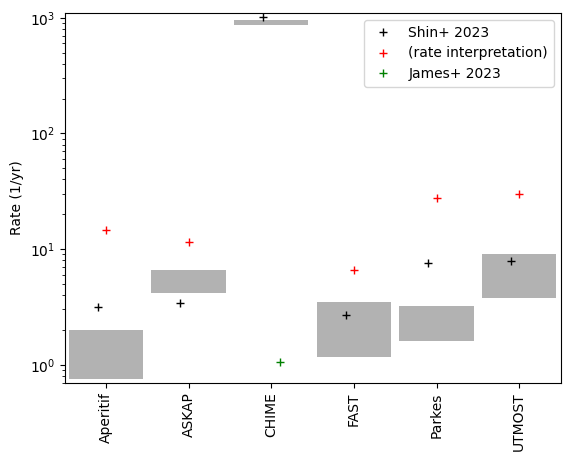

In [581]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()

x = np.arange(len(telescope_list))
#ax.errorbar(x-0.1, shin_values, yerr=shin_uncert, fmt='k+', label='Shin+ 2023', zorder=5)
#ax.errorbar(x, shin_values_r, yerr=shin_uncert_r, fmt='r+', label='(rate interpretation)', zorder=5)
#ax.errorbar(x+0.1, james_values, yerr=james_uncert, fmt='g+', label='James+ 2023', zorder=5)

ax.plot(x-0.1, shin_values, 'k+', label='Shin+ 2023', zorder=5)
ax.plot(x, shin_values_r, 'r+', label='(rate interpretation)', zorder=5)
ax.plot(x+0.1, james_values, 'g+', label='James+ 2023', zorder=5)


for telescope, xi in zip(telescope_list, x):
    rate = telescope_rates[telescope]
    rect = Rectangle(
        (xi - 0.45, (rate[0] - rate[1]).to(1/u.yr).value),
        0.9,
        rate[1].to(1/u.yr).value * 2,
        alpha=0.3,
        color='k',
        ec=None
    )
    ax.add_patch(rect)

ax.legend()
ax.set_yscale('log')
ax.set_xlim(x.min()-0.5, x.max()+0.5)
ax.set_ylim(0.7, 1100)
ax.set_xticks(x)
ax.set_xticklabels(telescope_list, rotation='vertical')
ax.set_ylabel("Rate (1/yr)")

In [327]:
(10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr)

<Quantity 9.12010839e+10 1 / (Gpc3 yr)>

In [343]:
gamma = -0.95+0.18
Echar = 10**41.26
(10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr) * (
    float(gammainc(gamma, (1e39*u.erg / Echar).value)) / 
    float(gammainc(gamma, (1e30*u.erg / Echar).value))
)

<Quantity 10140.48186066 1 / (Gpc3 yr)>

In [8]:
(
    float(gammainc(gamma + 1, (1e39*u.erg / Echar).value)) / 
    float(gammainc(gamma + 1, (1e30*u.erg / Echar).value))
)

0.2897268536490609

In [344]:
9e4

90000.0

In [ ]:
# Follow-up
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

In [4]:
source_low_dec = SkyCoord(ra=0*u.deg, dec=-10*u.deg)
source_mid_dec = SkyCoord(ra=0*u.deg, dec=45*u.deg)
source_high_dec = SkyCoord(ra=0*u.deg, dec=89*u.deg)

In [5]:
gbt = EarthLocation.of_site('GBT')
gmrt = EarthLocation.of_site('GMRT')
eff = EarthLocation.of_site('Effelsberg')

90.0% of time the source can be observed


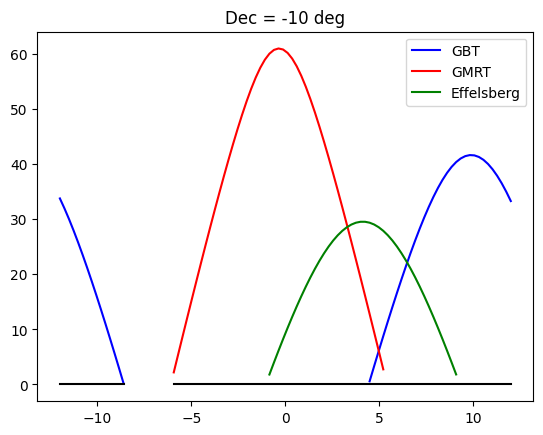

In [26]:
# Low dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_low_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_low_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_low_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = -10 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


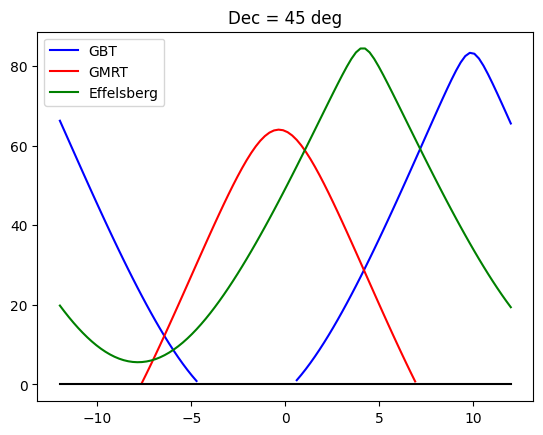

In [27]:
# Mid dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_mid_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_mid_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_mid_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 45 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


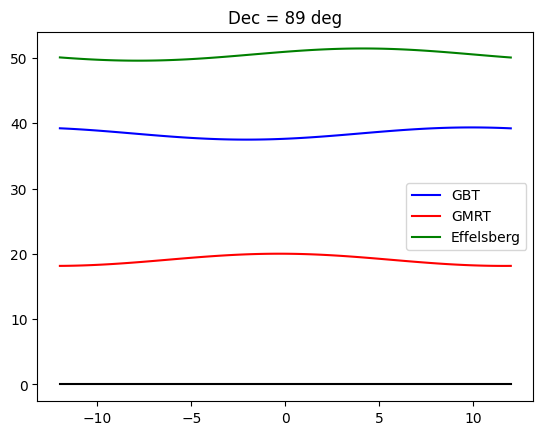

In [28]:
# High dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_high_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_high_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_high_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 89 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

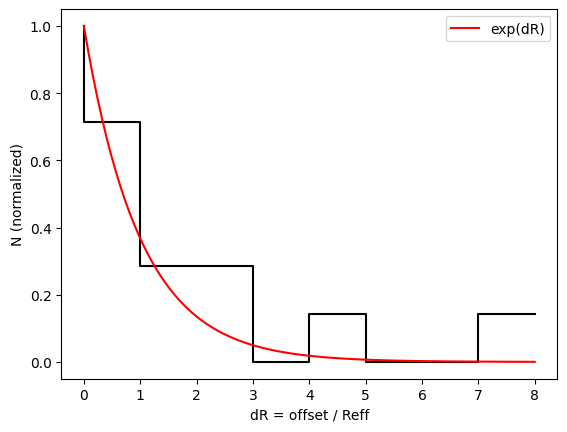

In [1125]:
# FRB radial distribution within host galaxies

#https://arxiv.org/pdf/2009.10747.pdf
#https://arxiv.org/pdf/2302.14782.pdf
#https://arxiv.org/pdf/2108.01282.pdf
#https://arxiv.org/pdf/2301.01000.pdf

# i-band and r-band
offset = np.array([0.6, 5.5, 3.4, 1.2, 2.0, 27, 6.6, 11, 3.2, 1.9, 11, 3.0, 9.87, 3.80, 10.8, 5.7, 5.9, 2.3])
reff = np.array([0.7, 3.6, 2.7, 7.2, 4.4, 3.3, 2.8, 2.1, 2.9, 3.9, 5.5, 1.6, 2.67, 6.64, 5.80, 1.78, 7.58, 2.7])

r = np.sort(offset / reff)
F = np.arange(r.size)/r.size

from scipy import stats
y_hist, bins = np.histogram(r, bins=np.arange(10))
x_hist = bins[:-1]
plt.step(x_hist, y_hist/y_hist.max(), color='k')


x = np.linspace(x_hist.min(), x_hist.max(), 100)
y = np.exp(-x)
#y = y / y.max() * 7
plt.plot(x, y, 'r-', label='exp(dR)')
plt.xlabel('dR = offset / Reff')
plt.ylabel('N (normalized)')
plt.legend()

In [ ]:
# OLD FUNCTIONS

class FRB_Population:
    """
    Parameters of the FRB population.
    """
    parameters = {
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': [2.38e41, +5.35e41, -1.64e41, 0] * u.erg,  # Characteristic energy cut-of
            'alpha_spect': [-1.39, +0.86, -1.19],  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': [-1.3, +0.7, -0.4],  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [7.3e4, +8.8e4, -3.8e4, 0] / u.Gpc**3/u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': [0.96, +0.81, -0.67],  # Index of star-formation rate
        },
        'shin_rate_interpretation': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': [1.95e41, +3.75e41, -1.28e41, 0] * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': [-1.10, +0.67, -0.99],  # Spectral index
            'gamma': [-1.3, +0.8, -0.5],  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [6.8e4, +8.3e4, -3.6e4, 0] / u.Gpc**3/u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': [1.72, +1.48, -1.10],  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': [1.82e41, +1.57e41, -7.23e40, 0]  * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': [-0.99, +0.99, -1.01],  # Spectral index
            'gamma': [-0.95-1, +0.18, -0.15],  # Differential power-law index
            'n_sfr': [1.13, +0.49, -0.41],  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': [6.8e4, +8.3e4, -3.6e4, 0] / u.Gpc**3/u.year # (10**1.96/u.Mpc**3/u.yr).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        self.parameters = FRB_Population.parameters
        try:
            _ = self.parameters[self.model]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
            
    def get_uncert_params(self, model = None):
        if model is None: model = self.model
        parameters = dict(self.parameters[model])
        ii = 0
        for key,value in parameters.items():
            try:
                size = len(value)
                ii += 1
            except TypeError:
                # No uncertianty for single values
                continue
        return ii
                
    def get_parameters(self, model = None, uncertain = False):
        if model is None: model = self.model
        parameters = dict(self.parameters[model])
        for key,value in parameters.items():
            try:
                size = len(value)
            except TypeError:
                # No uncertianty for single values
                continue
            if not uncertain:
                # If no uncertainty is needed, return the value
                parameters[key] = value[0]
                continue
            # If the uncertainty is 2-sided, randomly choose one
            err = value[rng.choice([1,2])]
            # Gaussian error
            sign = err // abs(err)
            if (size < 4) or (sign > 0):
                try:
                    random_err = rng.normal(scale = abs(err.value)) * err.unit
                except AttributeError:
                    # If the value has no units
                    random_err = rng.normal(scale = abs(err))
            else:
                # Quantities defined only above a threshold, e.g. Energy>0
                try:
                    random_err = truncnorm.rvs(
                        (-value[0] + value[3]) / abs(err.value),
                        (value[0] - value[3]) / abs(err.value),
                        scale=abs(err.value),
                        random_state=rng
                    ) * err.unit
                except AttributeError:
                    # If the value has no units
                    random_err = truncnorm.rvs(
                        (-value[0] + value[3]) / abs(err),
                        (value[0] - value[3]) / abs(err),
                        scale=abs(err),
                        random_state=rng
                    )
            parameters[key] = value[0] + np.abs(random_err) * sign
        return parameters


In [208]:
m.min(), m.max()

(<Quantity 3.41157474e+09 solMass>, <Quantity 8.78159517e+11 solMass>)

In [1]:
# Create galaxy csv
import pandas as pd
import numpy as np
from numpy.random import default_rng

seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility

# Tom's simulations
euclid_sim = pd.read_csv('lenses_Euclid.txt', delim_whitespace=True)

# Ana's simulations
dfs = list()
for ii in np.arange(0.01, 1, 0.01):
    jj = round(ii, 2)
    tab = pd.read_csv(f"SIE/positions_mu_t_q={jj}.csv", index_col=0)
    tab["q"] = jj
    dfs.append(tab)
magnification_sim = pd.concat(dfs, ignore_index=True)

# Distance between the lens and the fast radio burst
dist_lens_host = np.sqrt(euclid_sim['x_s_unlensed']**2 + euclid_sim['y_s_unlensed']**2)
dist_host_frb = rng.exponential(1) * euclid_sim['halflightradius_s(arcsec)']
dist_lens_frb = dist_lens_host + dist_host_frb * np.cos(rng.uniform(low=0, high=2*np.pi))

# Clip ellipticity to match Ana's simulations
euclid_sim['q_l'] = np.clip(euclid_sim['q_l'], 0.01, 0.99)

# For each source galaxy, select the backround source closest to the FRB position
rand_index = []
for q, d in zip(euclid_sim['q_l'], dist_lens_frb):
    rand_index.append(
        (
            magnification_sim['weights'][np.isclose(magnification_sim['q'], q)] - d
        ).abs().idxmin()
    )
    
# Table with all images for each host galaxy
total_table = pd.concat([euclid_sim, magnification_sim.iloc[rand_index].reset_index()], axis=1)

In [3]:
total_table.iloc[11]

z_l                               0.960000
z_s                               3.600000
R_Ein(arcsec)                     0.460000
sigma(km/s)                     173.350000
q_l                               0.670000
halflightradius_l(arcsec)         0.360000
mag_l_VIS                        23.610000
x_s_unlensed                      0.170000
y_s_unlensed                      0.180000
q_s                               0.700000
pa_s(degrees)                   138.100000
halflightradius_s(arcsec)         0.130000
mag_s_VIS                        24.740000
averagemagnification              3.650000
SNRofSource                      46.250000
M_absolute_source_r             -21.330000
index                        283340.000000
RA                                0.278043
DEC                              -0.601967
N_images                          2.000000
mu_tot                            2.645720
tmax                             38.677139
im1_RA                            0.540745
im1_DEC    

In [5]:
# https://www.imprs-astro.mpg.de/sites/default/files/lyskova.pdf

from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo

m = (
    1.6 * 
    (np.array(euclid_sim['sigma(km/s)'])*u.km/u.s)**2 *
    (np.array(euclid_sim['halflightradius_l(arcsec)'])*u.arcsec).to(u.rad).value *
    cosmo.angular_diameter_distance(np.array(euclid_sim['z_l'])) / 
    const.G
).to(u.M_sun)

In [6]:
a = pd.DataFrame()
a['impact_parameter'] = dist_lens_frb / euclid_sim['halflightradius_l(arcsec)']
a['lens_mass'] = m.value
a['sigma(km/s)'] = euclid_sim['sigma(km/s)']
a['halflightradius_l(arcsec)'] = euclid_sim['halflightradius_l(arcsec)']

In [9]:
a.to_csv('b_mass.csv', sep=' ', index=False)

In [14]:
a['impact_parameter'].max()

11.32378210982464

In [18]:
# Clip ellipticity to match Ana's simulations
euclid_sim['q_l'] = np.clip(euclid_sim['q_l'], 0.01, 0.99)

In [19]:
# Distance between the lens and the fast radio burst
dist_lens_host = np.sqrt(euclid_sim['x_s_unlensed']**2 + euclid_sim['y_s_unlensed']**2)
dist_host_frb = rng.exponential(1) * euclid_sim['halflightradius_s(arcsec)']
dist_lens_frb = dist_lens_host + dist_host_frb * np.cos(rng.uniform(low=0, high=2*np.pi))

In [20]:
dist_lens_frb_Er = dist_lens_frb / euclid_sim['R_Ein(arcsec)']

In [1]:
dist_lens_host

NameError: name 'dist_lens_host' is not defined

In [27]:
tom_sim = euclid_sim.iloc[0]
ana_sim = magnification_sim

In [28]:
frb_host_dist = rng.exponential(1) * tom_sim['halflightradius_s(arcsec)'] * u.arcsec
frb_host_angle = rng.uniform(low=0, high=2*np.pi) * u.rad
frb_host_x = frb_host_dist * np.cos(frb_host_angle)
frb_host_y = frb_host_dist * np.sin(frb_host_angle)
frb_lens_x = frb_host_x + tom_sim['x_s_unlensed'] * u.arcsec
frb_lens_y = frb_host_y + tom_sim['y_s_unlensed'] * u.arcsec

In [29]:
frb_lens_x_Er = frb_lens_x / tom_sim['R_Ein(arcsec)'] / u.arcsec
frb_lens_y_Er = frb_lens_y / tom_sim['R_Ein(arcsec)'] / u.arcsec

In [34]:
ana_sample = ana_sim[np.isclose(ana_sim['q'], tom_sim['q_l'])]
dist = np.sqrt((ana_sample['RA'] - frb_lens_x_Er)**2 + (ana_sample['DEC'] - frb_lens_y_Er)**2)
images = ana_sample.iloc[dist.argmin()]

In [39]:
position_RA = images['im1_RA'] * tom_sim['R_Ein(arcsec)'] * u.arcsec
position_DEC = images['im1_DEC'] * tom_sim['R_Ein(arcsec)'] * u.arcsec

In [40]:
images['t1'] * (tom_sim['R_Ein(arcsec)'] * u.arcsec)**2

RA          -0.463644
DEC         -0.240981
N_images     2.000000
mu_tot       3.899615
tmax        29.046042
im1_RA      -1.309879
im1_DEC     -0.760587
mu_1         3.058855
t1           0.000000
im2_RA       0.424406
im2_DEC      0.198681
mu_2         0.840759
t2          29.046042
im3_RA       0.000000
im3_DEC      0.000000
mu_3         0.000000
t3           0.000000
im4_RA       0.000000
im4_DEC      0.000000
mu_4         0.000000
t4           0.000000
weights      0.522529
q            0.920000
Name: 408612, dtype: float64

In [11]:
euclid_sim

,z_l,z_s,R_Ein(arcsec),sigma(km/s),q_l,halflightradius_l(arcsec),mag_l_VIS,x_s_unlensed,y_s_unlensed,q_s,pa_s(degrees),halflightradius_s(arcsec),mag_s_VIS,averagemagnification,SNRofSource,M_absolute_source_r
0,0.44,1.07,1.30,295.82,0.92,0.76,17.86,-0.40,-0.01,0.67,177.36,0.21,24.96,7.81,30.28,-20.06
1,1.07,2.00,0.45,217.65,0.83,0.38,23.47,-0.03,0.10,0.58,20.77,0.24,25.50,5.05,25.76,-21.17
2,0.46,2.38,0.51,160.18,0.75,0.44,20.76,0.10,0.07,0.48,5.44,0.15,25.97,7.49,23.09,-21.12
3,0.74,1.10,1.05,374.43,0.66,1.02,18.61,0.26,0.60,0.80,46.51,0.70,23.32,3.34,36.79,-22.22
4,1.04,2.26,0.67,244.34,0.42,0.88,22.80,0.03,-0.64,0.69,68.63,0.13,25.43,4.14,34.38,-21.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169585,0.81,1.85,0.67,231.66,0.70,0.49,21.65,-0.01,0.12,0.67,142.40,0.34,25.21,5.70,26.52,-21.48
169586,0.17,1.18,0.85,191.20,0.64,1.07,17.29,0.11,0.42,0.86,20.61,0.03,26.25,7.86,23.47,-18.93
169587,0.82,2.23,0.61,209.02,0.62,0.36,22.01,0.08,0.14,0.91,128.08,0.07,26.37,7.69,24.70,-20.44
169588,1.50,2.50,0.41,239.13,0.79,0.49,25.34,0.16,-0.03,0.47,105.12,0.13,25.22,4.50,38.71,-21.95


In [7]:
import pandas as pd

In [8]:
euclid_sim = pd.read_csv('lenses_Euclid.txt', delim_whitespace=True)

In [9]:
dist_lens_host = np.sqrt(euclid_sim['x_s_unlensed']**2 + euclid_sim['y_s_unlensed']**2)

In [15]:
(
    (np.array(dist_lens_host) * u.arcsec).to(u.rad) * 
    cosmo.angular_diameter_distance(np.array(euclid_sim['z_l']))
).to(u.kpc, equivalencies=u.dimensionless_angles())

<Quantity [2.34553033, 0.87198583, 0.73381534, ..., 1.2557369 , 1.41339675,
           1.85286709] kpc>